# Graphene Raman: peak fitting of D, G and 2D

This is a fitting script for Raman spectra of graphene, to determine important characteristics like the ratio of the defect (D) peak to the graphite (G) peak or the symmetry of the the 2D peak.

## Graphene Raman peaks

The main graphene peaks are modeled as lmfit [Pseudo Voigt peaks](https://lmfit.github.io/lmfit-py/builtin_models.html#pseudovoigtmodel).

The script is aimed at a standard evaluation of these properties for multiple spectra, to obtain reasonable statistics.

In [1]:
#The default definition of peaks and ranges in the graphene spectrum
GRAPHENEPEAKS = [
    {
        #The name of the peak
        'prefix': 'D',
        #The range in the spectrum: baseline correction will irgnore this range
        'range': {'min': 1290.0, 'max': 1420.0},
        #constraints for the peak position
        'center': {'min': 1340.0, 'init': 1350, 'max': 1360.0, 'vary': True},
        #constraints for the peak width
        'sigma': {'min': 5.0, 'init': 30.0, 'max': 40.0, 'vary': True},
        #constraints for the gaussian to lorentzian ratio
        'fraction': {'min': 0.01, 'init': 0.8, 'max': 1.0, 'vary': True},
        #constraints for the peak height
        'amplitude': {'min': 0.0, 'vary': True},
        #If set to False, the peak will not be fitted, only initialized
        'vary': True
    },
    {
        #The name of the peak
        'prefix': 'G',
        #The range in the spectrum: baseline correction will irgnore this range
        'range': {'min': 1480.0, 'max': 1700.0},
        #constraints for the peak position
        'center': {'min': 1560.0, 'init': 1585.0, 'max': 1610.0, 'vary': True},
        #constraints for the peak width
        'sigma': {'min': 5.0, 'init': 25.0, 'max': 50.0, 'vary': True},
        #constraints for the gaussian to lorentzian ratio
        'fraction': {'min': 0.01, 'init': 0.4, 'max': 1.0, 'vary': True},
        #constraints for the peak height
        'amplitude': {'min': 0.0, 'vary': True},
        #If set to False, the peak will not be fitted, only initialized
        'vary': True
    },
    {
        #The name of the peak
        'prefix': 'Dplus',
        #The range in the spectrum: baseline correction will irgnore this range
        'range': {'min': 2350.0, 'max': 2540.0},
        #constraints for the peak position
        'center': {'min': 2420.0, 'init': 2450.0, 'max': 2500.0, 'vary': True},
        #constraints for the peak width
        'sigma': {'min': 5.0, 'init': 25.0, 'max': 50.0, 'vary': True},
        #constraints for the gaussian to lorentzian ratio
        'fraction': {'min': 0.01, 'init': 0.4, 'max': 1.0, 'vary': True},
        #constraints for the peak height
        'amplitude': {'min': 0.0, 'vary': True},
        #If set to False, the peak will not be fitted, only initialized
        'vary': False
    },
    {
        #The name of the peak
        'prefix': 'twoD',
        #The range in the spectrum: baseline correction will irgnore this range
        'range': {'min': 2580.0, 'max': 2790.0},
        #constraints for the peak position
        'center': {'min': 2650.0, 'init': 2670, 'max': 2750.0, 'vary': True},
        #constraints for the peak width
        'sigma': {'min': 5.0, 'init': 25.0, 'max': 80.0, 'vary': True},
        #constraints for the gaussian to lorentzian ratio
        'fraction': {'min': 0.01, 'init': 0.4, 'max': 1.0, 'vary': True},
        #constraints for the peak height
        'amplitude': {'min': 0.0, 'vary': True},
        #If set to False, the peak will not be fitted, only initialized
        'vary': True
    }
]


The required packages are mostly part of the anaconda distribution. [lmfit](https://lmfit.github.io/lmfit-py/) is installed separately. Tested with Python 3.5.2 and lmfit 0.9.5

In [2]:
%load_ext autoreload
%autoreload 2

## Multi-peak module

For clear arrangement, the multi-peak module is in the "multipeak" folder. Make changes there in the .py files, if you want to customize the evaluation.

In [3]:
#from multipeak import Dataset, MultiPseudoVoigtModel, GrapheneModelResults, printmd
import multipeak
from copy import deepcopy

In [4]:
from sys import version as pythonVersion
from lmfit._version import get_versions
print('Python version:', pythonVersion)
print('lmfit version:', get_versions()['version'])

Python version: 3.5.2 | packaged by conda-forge | (default, Jul 26 2016, 02:06:09) [MSC v.1900 64 bit (AMD64)]
lmfit version: 0.9.5


This is to prevent cell scrolling for longer outputs:

In [5]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Fitting task

µ-Raman spectra (100X objective) of graphene have to be supplied in a text file, with the Ramanshift in cm<sup>-1</sup> and the intensity in separate columns. The resolution should be better than 1.5 cm<sup>-1</sup>, the range from at least from 1265 cm<sup>-1</sup> to 2810 cm<sup>-1</sup> for fitting of the default peaks.

The file can contain multiple datasets with an equal number of datapoints, each dataset is then individually processed and average values and histograms are generated.

Optionally, the data will be cut to the range specified by TASK['xmin'] and TASK['xmax'].

The default fitting uses separate fitting tasks with specific baseline subtraction for the D + G band and the 2D band. In general this leads to more robust results, compared to model a sigle baseline with a higher order polynomial. 

In [6]:
TASK = {
    #Filename as full path. The file can contain multiple datasets with an equal number of datapoints
    #'filename': 'examples/CVD_graphene_example.txt',  #optional
    
    #If filename is left unspecified a file dialog will open in:
    'initialDir': './',
    
    #Columns in the file to be used
    'posx_column': 0,  #optional
    'posy_column': 1,  #optional
    'x_column': 2, #raman shift
    'y_column': 3, #raman intensity
    
    #Axis labels for plotting
    'xlabel': 'Raman shift',
    'xunit': 'cm^{-1}',
    'ylabel': 'Intensity',
    'yunit': 'counts',
    
    #Set to the order of polynomial for baseline subtraction, 0 for no baseline
    #Maxium allowed value is 7
    #Note that this is ignored if a partially defined baseline is used
    'baselineOrder': 6,
    
    #Minimum signal-to-noise ratio, if 0 all speactra are used
    'snr': 100,
    
    #The minimum number of remaining spectra after signal-to-noise selection 
    'minimumStatisctics': 100, #evaluation according to the standard must include 100 spectra
    
    #Minium x value
    'xmin': 1200.0,  #optional
    #Maximum x value
    'xmax': 2810.0,  #optional
    
    #Dictionary where the peaks are defined
    'peaks': deepcopy(GRAPHENEPEAKS)
}

Customizations for pyplot figures:

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams.update({'font.size': 14})

## Datasets

The datasets are read from a text file using TASK['filename'] with x and y columns defined in TASK['x_column'] and TASK['y_column'].

In [8]:
#we first read the data
DATASET = multipeak.Dataset(task=TASK, maxNumber=1000)

Reading  examples/CVD_graphene_example.txt
Data  examples/CVD_graphene_example.txt  read
Data reversed
121  datasets detected
Data cut:  1200.0 2810.0
Data reshaped
Weights arrays initialized


## Baseline subtraction and filtering

A partially defined polynomial baseline is subtracted from every dataset, using the following sequences:

In [9]:
"""Partially defined polynomial baseline"""
BASELINE = [
    {
        #partial baseline is defined
        'untilX': 1750.0,  #in wavenumbers
        #and has
        'polynomialOrder': 2,
        #and requires minimum signal-to-noise ratio
        'snr': 100  #which can be 0 to include all spectra
    },
    {
        'untilX': 2555.0,
        'polynomialOrder': 4,
        'snr': 0
    },
    {
        'untilX': 2810.0,
        'polynomialOrder': 1,
        'snr': 100
    }    
]

## Example baseline

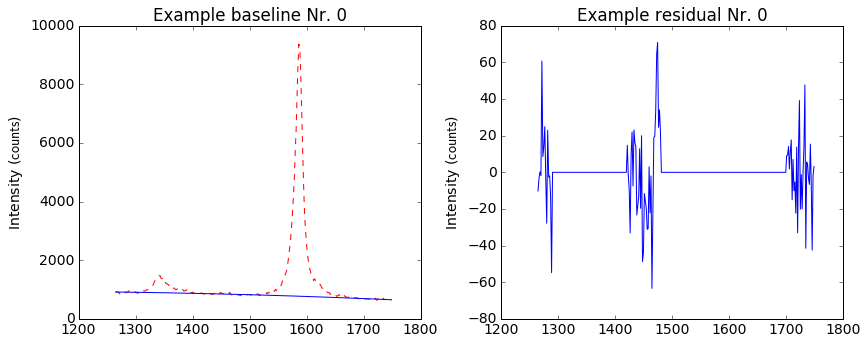

## Example baseline

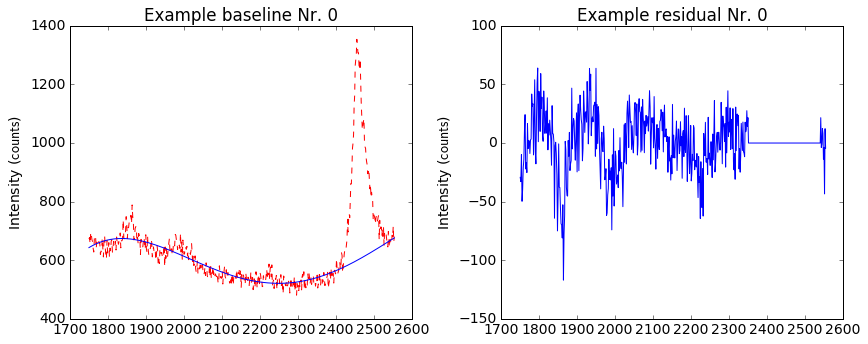

## Example baseline

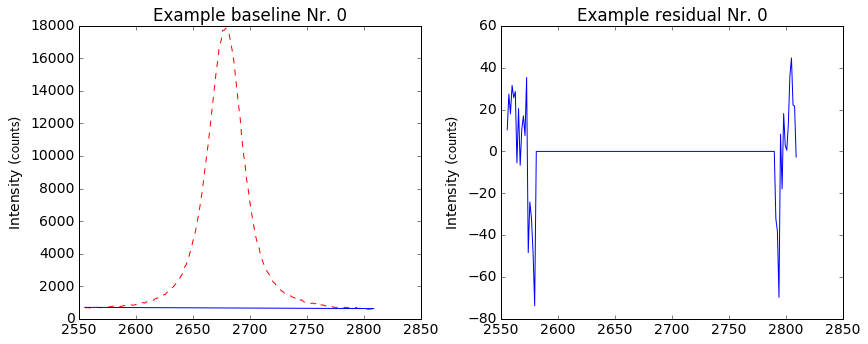

## Example for corrected spectrum

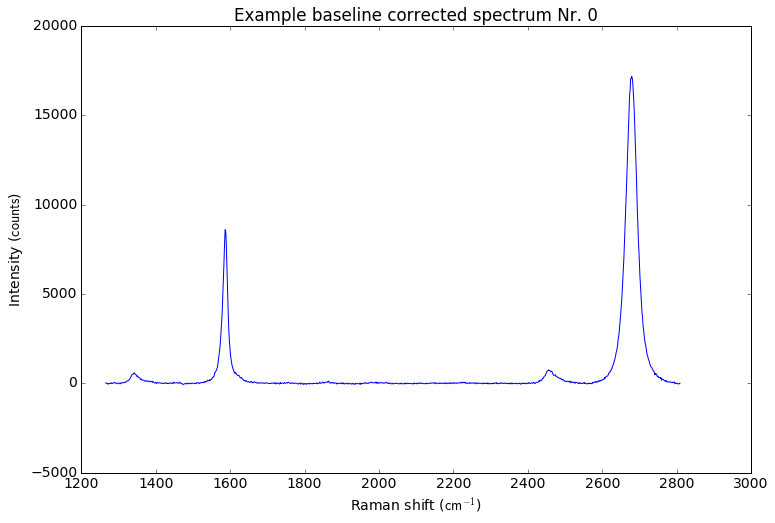

In [10]:
DATASET.subtractMultiBaseline(baselineParts=BASELINE, exampleSpec=0)

## Filtering

Datasets are omitted if the signal to noise ratio is lower than the value defined in the baseline parts. This is recommended, because for low signal spectra the evaluation is not reliable. The signal to noise ratio is determined by the squared variance of the data divided by the squared variance of the data points excluding the peak ranges.

In [11]:
DATASET.filterDatasetBySNR()

0 spectra were excluded from 121 datasets
121 datasets left for fitting


## Multi-peak model

Reads the peaks defined in TASK['peaks'] and builds and lmfit CompositeModel from them.

In [12]:
#finally we build and fit the model
GRAPHENEMODEL = multipeak.MultiPseudoVoigtModel(DATASET, weights=DATASET.weights['peaks'])

## 2D peak fitting

Here starts the actual data processing. Depending on the number of datasets this can take a while (for example 0.2s per spectrum).

In [13]:
GRAPHENEMODEL.runFit()

--- Fitting datasets started  Thu, 15 Dec 2016 13:43:35 +0000
--- Fit completed in 23.860999822616577 seconds ---


## Graphene fit results

This obejest takes the standard fit results from lmfit and provides multi-peak, multi-spectra and graphene specific evaluations.

In [14]:
#build the graphene specific evaluations from the array of fit results
RESULTS = multipeak.GrapheneModelResults(GRAPHENEMODEL, DATASET)

## Results

## Fit results

### Peak ratios

D/G area ratio,0.140 +/- 0.132
D/G height ratio,0.097 +/- 0.123
2D/G area ratio,3.196 +/- 1.010
2D/G height ratio,1.518 +/- 0.335


### 2D symmetry

Coefficient of determination of 2D single peak fitting,0.999 +/- 0.002
Normalized squared maximum 2D residual,0.001 +/- 0.001


## Fit of average spectrum

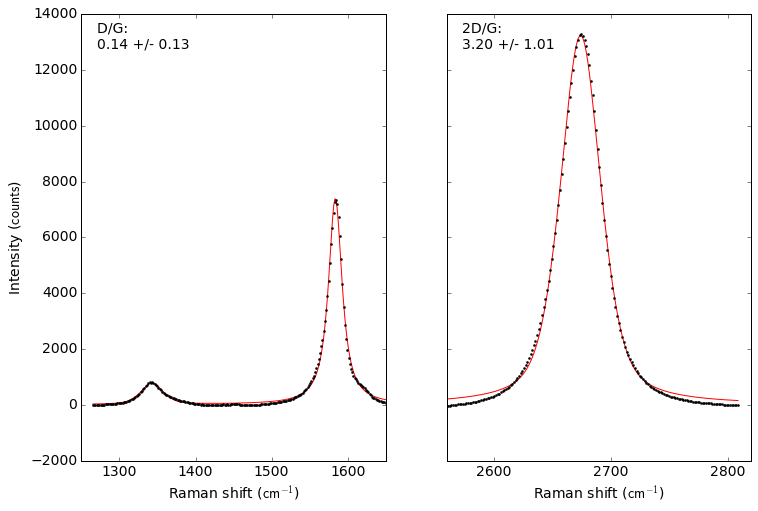

[[Model]]
    ((Model(pvoigt, prefix='D_') + Model(pvoigt, prefix='G_')) + Model(pvoigt, prefix='twoD_'))
[[Fit Statistics]]
    # function evals   = 175
    # data points      = 1014
    # variables        = 16
    chi-square         = 11473272.277
    reduced chi-square = 11496.265
    Akaike info crit   = 9496.547
    Bayesian info crit = 9575.293
[[Variables]]
    D_height:          989.832021 +/- 0        (0.00%)  == 'D_amplitude / D_fwhm'
    D_fraction:        0.56503839 +/- 0        (0.00%) (init= 0.8)
    D_center:          1342.66663 +/- 0        (0.00%) (init= 1350)
    D_sigma:           17.4112029 +/- 0        (0.00%) (init= 30)
    D_amplitude:       34468.3324 +/- 0        (0.00%) (init= 2.392861e+07)
    D_fwhm:            34.8224058 +/- 0        (0.00%)  == 'D_sigma * 2.0'
    G_height:          11360.8310 +/- 0        (0.00%)  == 'G_amplitude / G_fwhm'
    G_fraction:        0.95222191 +/- 0        (0.00%) (init= 0.4)
    G_center:          1583.60782 +/- 0        (0.

## Fitted spectra overview

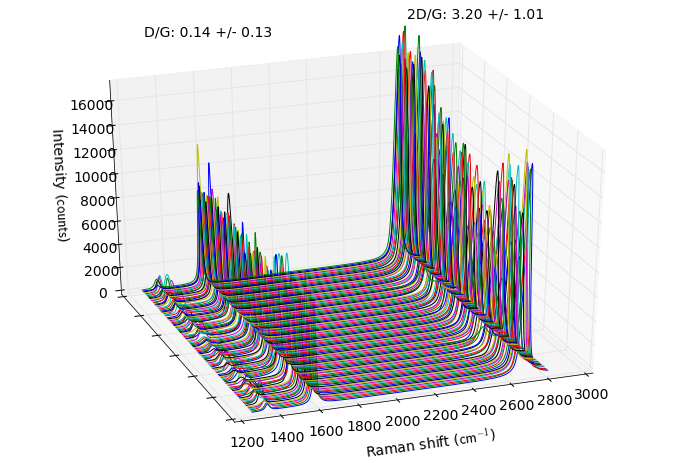

## 2D peak symmetry

### Normalized squared maximum residuals (NSR)

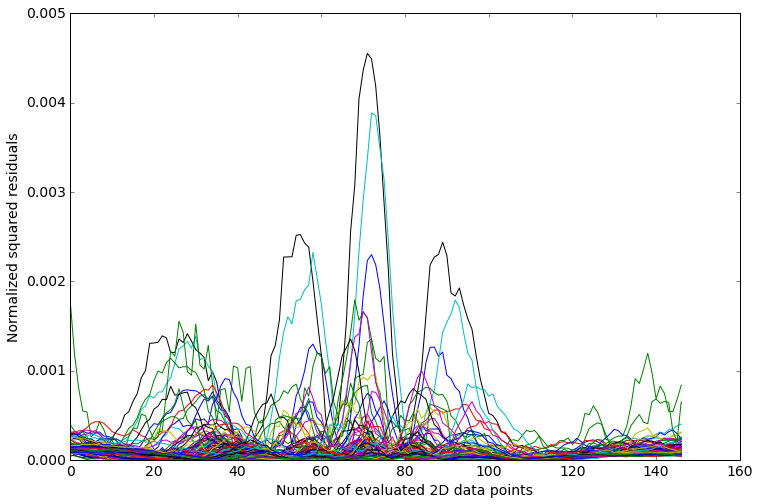

### 2D R2 intervals

Symmetric 2D shapes (R2 > 0.995): 95.87  %
Symmetric 2D shapes (R2 > 0.99): 99.17  %
Symmetric 2D shapes (R2 > 0.98): 100.00  %


### 2D peak R2: 0.999 +/- 0.002

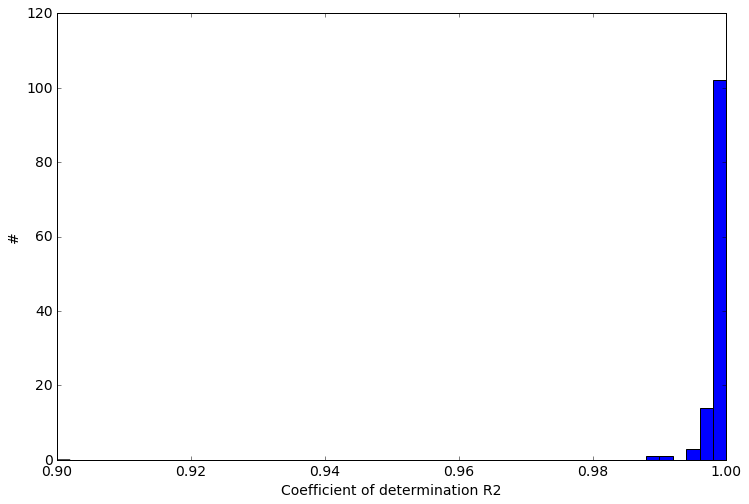

### 2D symmetry outliers

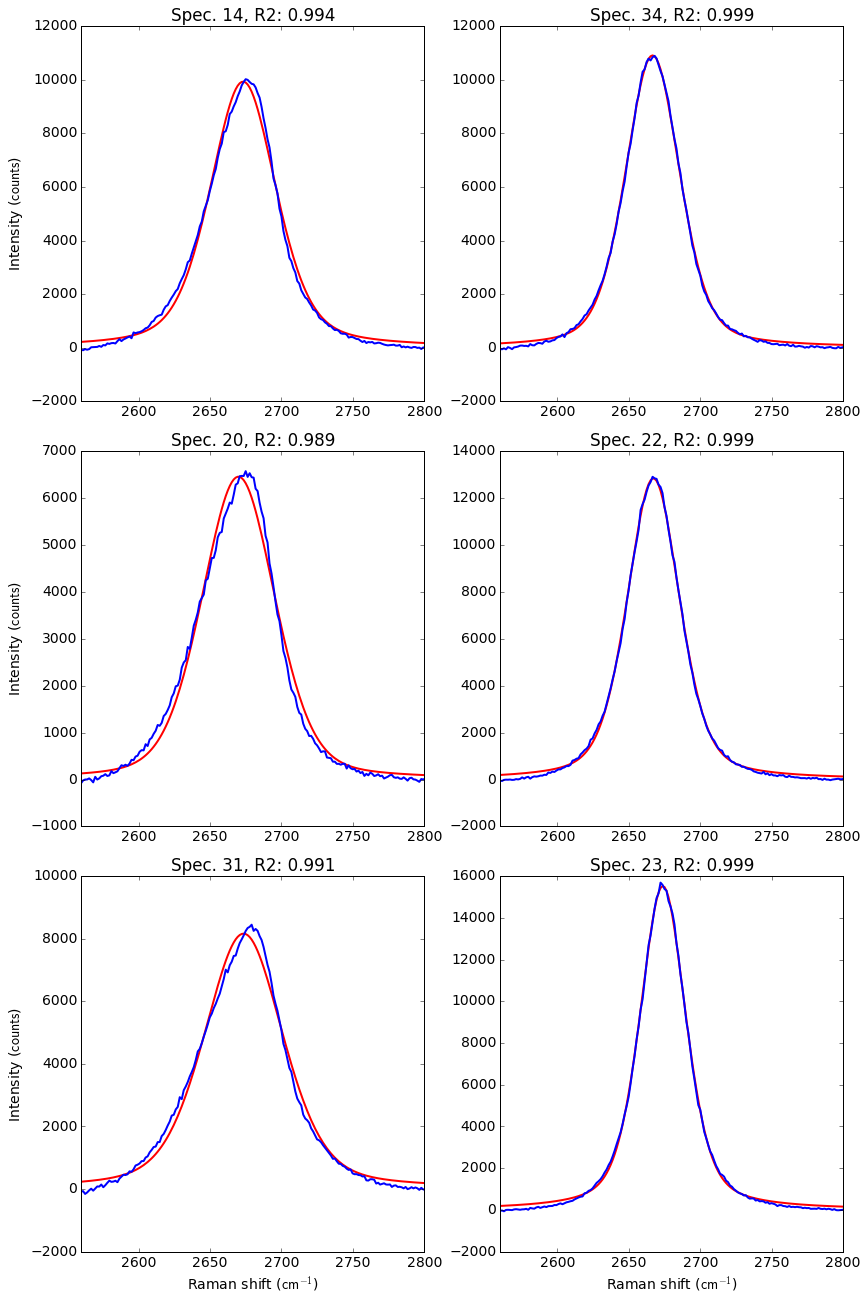

In [15]:
multipeak.printmd('## Fit results')
RESULTS.printPeakResultsTable()

multipeak.printmd('### Peak ratios')
RESULTS.printDerivedResultsTable(derivedParams=[
    'DtoG_area',
    'DtoG_height',
    'twoDtoG_area',
    'twoDtoG_height'
])
multipeak.printmd('### 2D symmetry')
RESULTS.printDerivedResultsTable(derivedParams=[
    'twoDr2',
    'twoDmaxRes'
])

multipeak.printmd('## Fit of average spectrum')
RESULTS.plotAvgFit(saveName='avgFit')
print(GRAPHENEMODEL.avgFitResult.fit_report())

multipeak.printmd('## Fitted spectra overview')
RESULTS.plot3D(save=True)

multipeak.printmd('## 2D peak symmetry')
multipeak.printmd('### Normalized squared maximum residuals (NSR)')
RESULTS.plot2Dresiduals()

multipeak.printmd('### 2D R2 intervals')
RESULTS.print2Dr2Intervals(0.995)
RESULTS.print2Dr2Intervals(0.99)
RESULTS.print2Dr2Intervals(0.98)
RESULTS.print2Dr2(save=True)

multipeak.printmd('### 2D symmetry outliers')
RESULTS.plot2DOutliers(3, save=True)

In [16]:
exampleFitNumber = 0
#multipeak.printmd('## Example fit')
#RESULTS.plotFit(exampleFitNumber)
#print(GRAPHENEMODEL.fitResults[exampleFitNumber].fit_report())

## D/G ratio

### D/G intervals

D/G < 0.2): 83.47  %
D/G < 0.5): 98.35  %
D/G < 0.8): 98.35  %
D/G < 1.0): 99.17  %


## Peak ratios

D/G ratio by area:  0.140 +/- 0.132
D/G ratio by height:  0.097 +/- 0.123


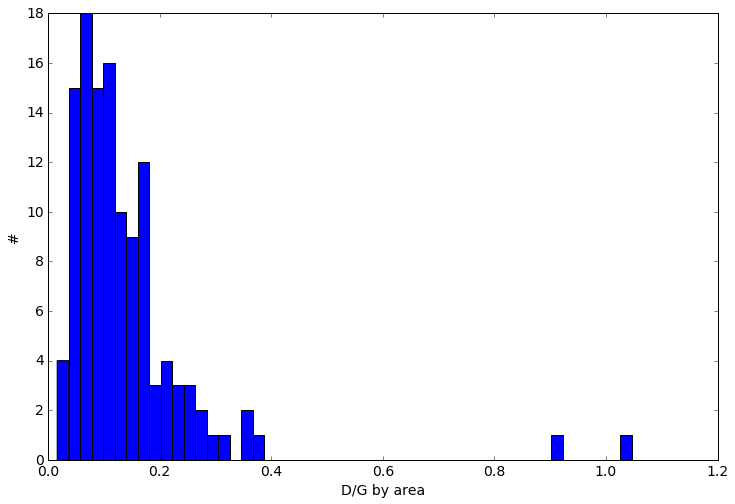

2D/G ratio by area:  3.1960982569  +/-  1.00997141454
2D/G ratio by height:  1.51768886608  +/-  0.334821658589


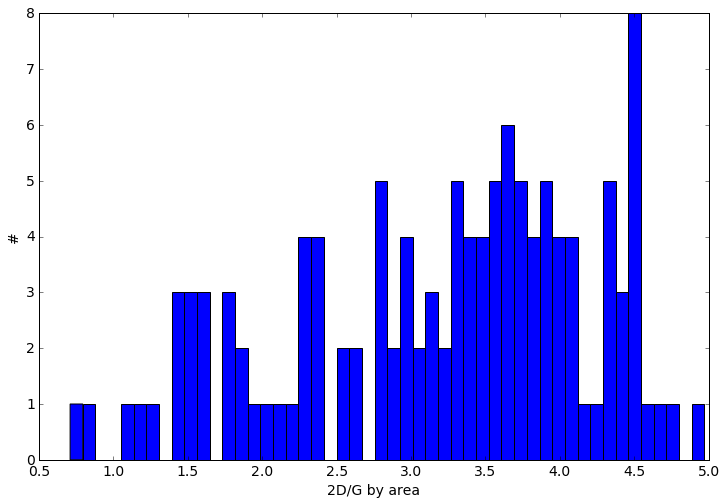

## D/G outliers

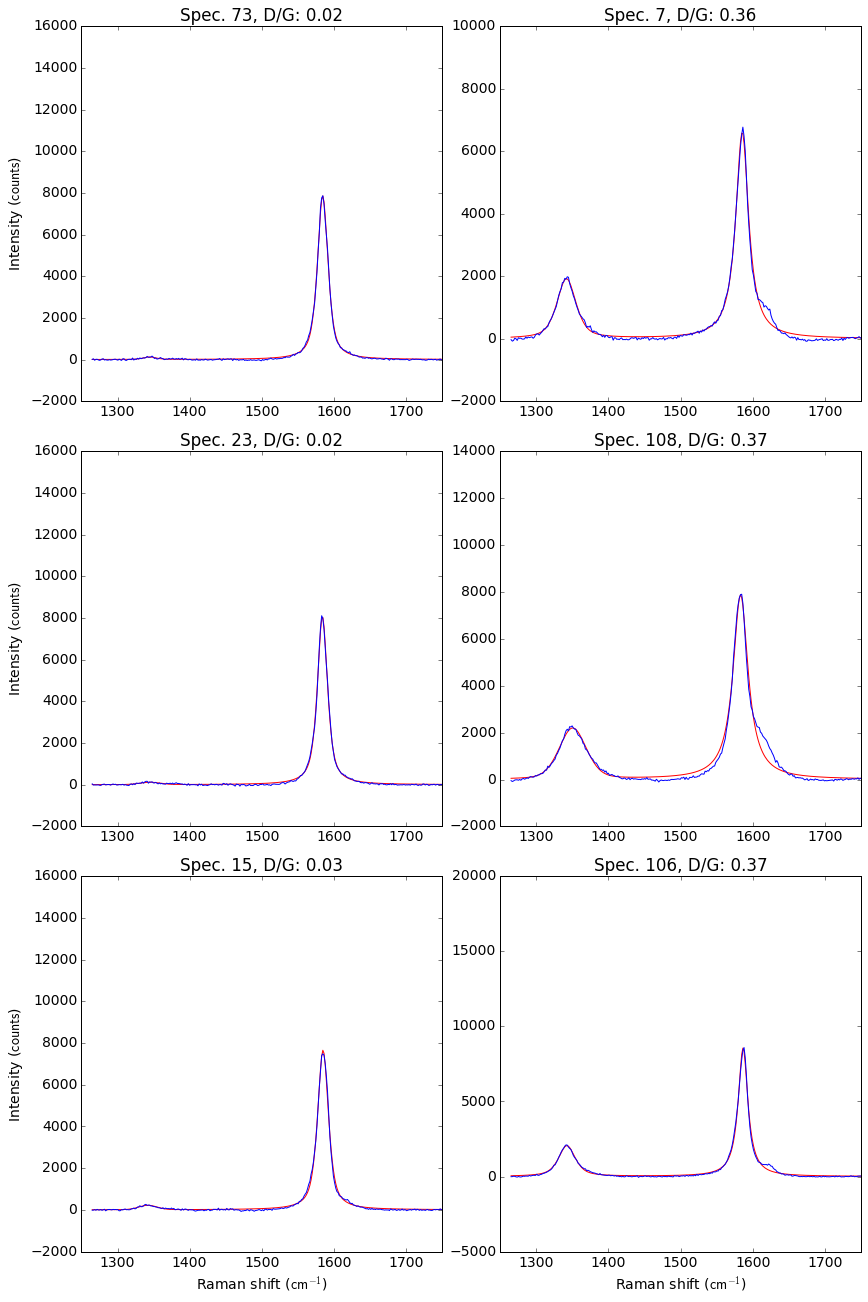

In [17]:
multipeak.printmd('## D/G ratio')

multipeak.printmd('### D/G intervals')
RESULTS.printDtoGIntervals(0.2)
RESULTS.printDtoGIntervals(0.5)
RESULTS.printDtoGIntervals(0.8)
RESULTS.printDtoGIntervals(1.0)

multipeak.printmd('## Peak ratios')
RESULTS.printPeakRatios(save=True)

multipeak.printmd('## D/G outliers')
RESULTS.plotDtoGOutliers(3, save=True)

## Other results

### Peak widths

D fwhm: 33.000 +/- 8.806
G fwhm: 21.506 +/- 8.352
twoD fwhm: 41.701 +/- 6.973


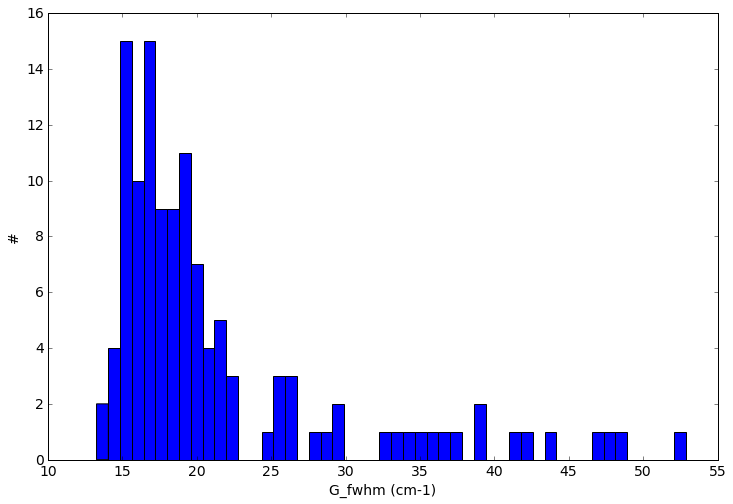

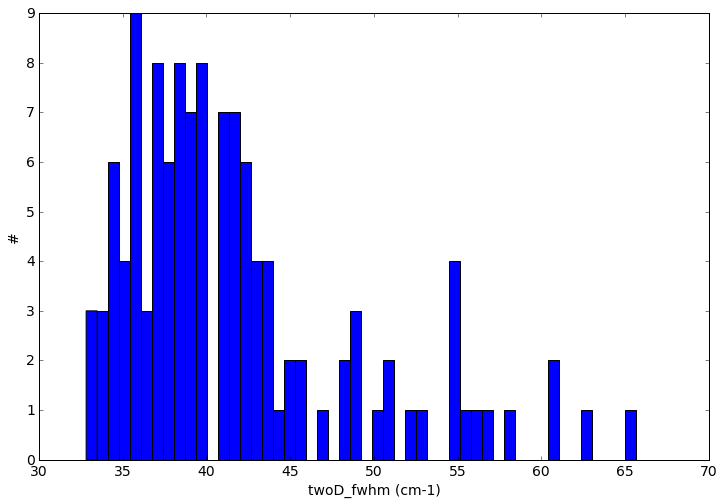

### Peak positions

D center: 1343.014 +/- 2.570
G center: 1583.340 +/- 3.753
twoD center: 2673.818 +/- 3.952


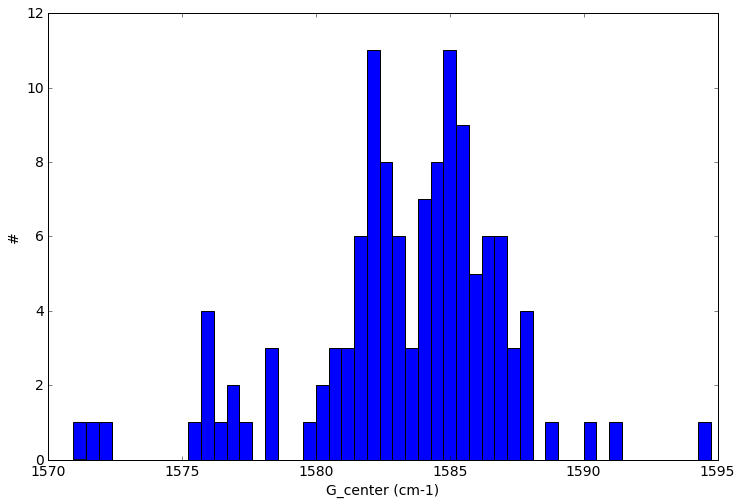

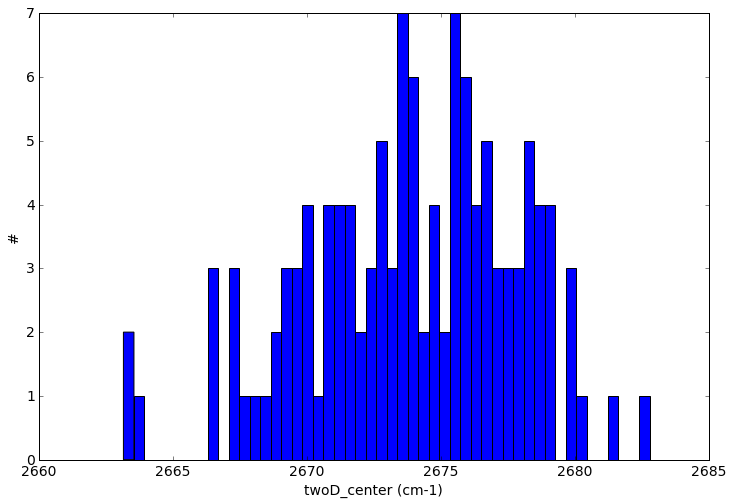

In [18]:
multipeak.printmd('## Other results')

multipeak.printmd('### Peak widths')
RESULTS.printParamResults('fwhm')
RESULTS.plotPeakParamHist('G', 'fwhm', xunit='cm-1', bins=50, saveName='G-width-hist')
RESULTS.plotPeakParamHist('twoD', 'fwhm', xunit='cm-1', bins=50, saveName='2D-width-hist')

multipeak.printmd('### Peak positions')
RESULTS.printParamResults('center')
RESULTS.plotPeakParamHist('G', 'center', xunit='cm-1', bins=50, saveName='G-position-hist')
RESULTS.plotPeakParamHist('twoD', 'center', xunit='cm-1', bins=50, saveName='2D-position-hist')

In [19]:
RESULTS.writeOutput('fitReport')
RESULTS.writePeakResultsTable('peakResults')

Results for each sprectrum saved as:  examples/CVD_graphene_example_fitReport.csv
Peak results saved as:  examples/CVD_graphene_example_peakResults.csv


### Evaluation average values as custom string
Print result String in desired format for import to Excel, Origin, ...

In [20]:
RESULTS.printAvgRes([
        'DtoG_area',
        'twoDr2',
        'DtoG_area',
        'G_fwhm',
        'twoD_fwhm',
        'G_amplitude',
        'twoDtoG_height'
    ], delimiter=' ')

<b>Format: </b> <b>|</b> D/G area ratio +/-  <b>|</b> Coefficient of determination of 2D single peak fitting +/-  <b>|</b> D/G area ratio +/-  <b>|</b> G_fwhm +/-  <b>|</b> twoD_fwhm +/-  <b>|</b> G_amplitude +/-  <b>|</b> 2D/G height ratio +/- 

<div style="width: 100%; height: 3px; background: grey; overflow: hidden;">

0.139916626018 0.132037316887 0.998607438735 0.00150956469831 0.139916626018 0.132037316887 21.5055810258 8.35173077761 41.7006296216 6.97299598631 240500.087618 80259.249422 1.51768886608 0.334821658589 


<div style="width: 100%; height: 3px; background: grey; overflow: hidden;">


Possible names are:
G_amplitude | G_height | D_fwhm | G_fwhm | G_center | D_height | twoD_sigma | twoD_center | twoD_fraction | D_fraction | twoD_fwhm | D_center | D_sigma | twoD_amplitude | G_fraction | twoD_height | G_sigma | D_amplitude | twoDr2 | DtoG_area | twoDtoG_height | twoDmaxRes | twoDtoG_area | DtoG_height | 


Hacky solution to save the evaluation result as a html page. Anyone who knows a better solution, go ahead!

In [21]:
%%javascript
IPython.notebook.save_notebook();

<IPython.core.display.Javascript object>

In [22]:
from nbconvert import HTMLExporter
import codecs
import nbformat
import time

time.sleep(1)
exporter = HTMLExporter()
output_notebook = nbformat.read('DtoG-2Dsymmetry.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(RESULTS.baseFilename + '.html', 'w', encoding='utf-8').write(output)

Good sciencing everyone!